### Imports

In [8]:
from google.colab import drive

import kagglehub
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.calibration import LabelEncoder
import torch.nn.functional as F
import torch.nn as nn
import os


import torchvision
import torchvision.transforms as transforms
# import torchvision.transforms as transforms

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
!ls
!ls "/content/drive/My Drive/Colab Notebooks/rice_classification"

Rice_Image_Dataset.zip
Rice_Image_Dataset.zip


### Colab Configurations

In [14]:
os.chdir("/content/drive/My Drive/Colab Notebooks/rice_classification")
print("Now working in:", os.getcwd())

Now working in: /content/drive/My Drive/Colab Notebooks/rice_classification


In [17]:
# run one-time
!unzip -q "Rice_Image_Dataset.zip" -d "./"

In [5]:
# path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")

# print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/rice-image-dataset


### Loading images

In [19]:
rice_classes = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
# path_to_imgs = "~/kaggle/input/rice-image-dataset"
path_to_imgs = './Rice_Image_Dataset/'

img_paths = []
labels = []

display(os.path.join(path_to_imgs, rice_classes[0]))
display(os.listdir(path_to_imgs))

for rice_name in rice_classes:
    class_path = os.path.join(path_to_imgs, rice_name)

    for item in os.listdir(class_path)[:]:
        img_path = os.path.join(class_path, item)
        img_paths.append(img_path)
        labels.append(rice_name.lower())


'./Rice_Image_Dataset/Arborio'

['Arborio',
 'Basmati',
 'Ipsala',
 'Jasmine',
 'Karacadag',
 'Rice_Citation_Request.txt']

In [20]:
rice_images_df = pd.DataFrame({'paths': img_paths, 'labels': labels})

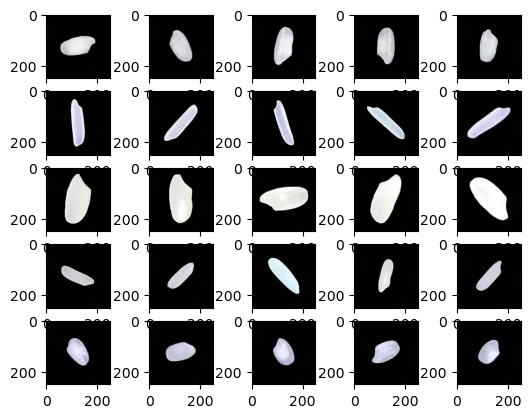

In [ ]:
IMGS_TO_SAMPLE = 5


imgs_by_labels = rice_images_df.groupby('labels')
sampled_df = imgs_by_labels.sample(IMGS_TO_SAMPLE, random_state = 0).reset_index()

for i in range(sampled_df.shape[0]):
    img = plt.imread(sampled_df.iloc[i]['paths'])
    plt.subplot(5, 5, i+1)
    plt.imshow(img)


### Exploratory data analysis

In [ ]:
display([0.2]*5)

[0.2, 0.2, 0.2, 0.2, 0.2]

(0.0, 20000.0)

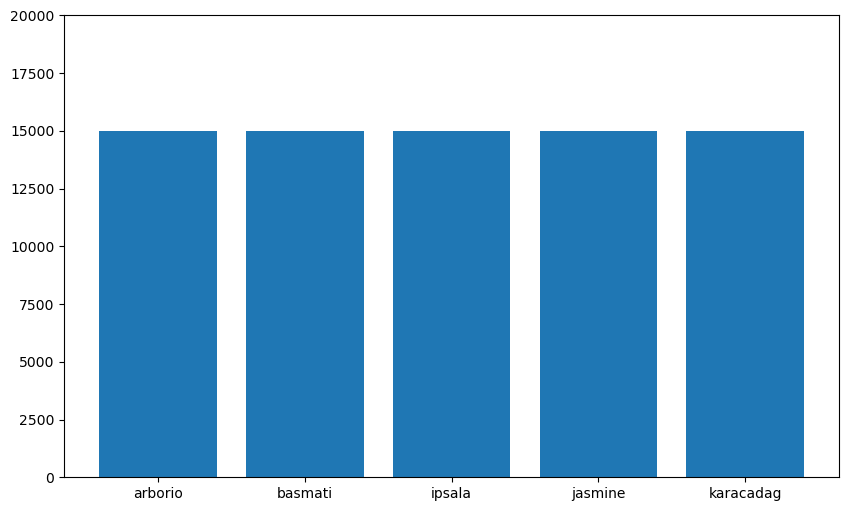

In [ ]:
# figuring out class statistics
class_dist = rice_images_df['labels'].value_counts()

plt.figure(figsize = (10, 6))
plt.bar(
    class_dist.index.to_list(),
    class_dist.values
)
plt.ylim(0, 20000)

### Image transformer

In [ ]:
test_img = plt.imread(rice_images_df.iloc[i]['paths'])


### Splitting data and encoding

In [ ]:
from sklearn.calibration import LabelEncoder


le = LabelEncoder()
rice_images_df['labels'] = le.fit_transform(
    rice_images_df['labels']
)


In [ ]:
class DenseLayer(nn.Module):

    def __init__(self, num_features, num_neurons, activation_fn = torch.nn.Sigmoid,
                 loss_fn):
        self.num_features = num_features
        self.num_neurons = num_neurons
        self.activation_fn = activation_fn()
        self.loss_fn = loss_fn

        gen = torch.Generator()
        gen.manual_seed(0)

        self.init_weights()

    def init_weights(self):
        self.W = torch.normal(0, 0.1, size = (self.num_features, self.num_neurons))
        self.b = torch.zeroes((1, self.num_neurons))
        # self.z = torch.zeros(())

    def forward(self, X):
        pre_activated = X @ self.W + self.b
        activated = self.activation_fn(pre_activated)

        return activated